# Continous motion classification


In this project we will use Machine Learning to detect which gesture the user is performing by means of the accelerometer and gyroscope data coming from an IMU (Inertia Measurement Unit) sensor.

This task differs from the previous ones since it involves *time* as a feature. We are no more working with static data: we'll work with values that change over time.

We will learn that, when dealing with time series data, we need to use a *windowing scheme*, to groups sensor readings in chunks to be processed. From each chunk we can later extract a set of *spectral features* to use as inputs for classification.

This project is a replica of [the one from Edge Impulse](https://docs.edgeimpulse.com/docs/tutorials/continuous-motion-recognition). Instead of using Neural Networks, though, we will use a "traditional" classifier.

## Hardware requirements

To follow this project you need an IMU sensor.

It can either be built-in your board (e.g Arduino BLE Sense) or an external sensor (e.g. MPU9250).

## Software requirements

To implement the Machine Learning part in Python you will need the [`everywhereml`](https://github.com/eloquentarduino/everywhereml) library.

In [6]:
# !pip install everywhereml>=0.0.3

## Data collection

We will collect training data via the Serial port of your PC.

If you followed the [Fruit classification](#) project, the next piece of code will look familiar.

First of all, create a sketch that is able to print accelerometer and gyroscope data. This will change based on your board and sensor; here is an example for the Arduino BLE Sense.

```cpp
// file IMUCollect.ino

#include <Arduino_LSM9DS1.h>


void setup() {
  Serial.begin(115200);
  while (!Serial);
  Serial.println("Started");

  if (!IMU.begin()) {
    Serial.println("Failed to initialize IMU!");
    while (1);
  }

  Serial.print("Accelerometer sample rate = ");
  Serial.print(IMU.accelerationSampleRate());
  Serial.println("Hz");
}

void loop() {
  float ax, ay, az, gx, gy, gz;
  
  if (!IMU.accelerationAvailable() || !IMU.gyroscopeAvailable())
    return;
    
  IMU.readAcceleration(ax, ay, az);
  IMU.readGyroscope(gx, gy, gz);

  Serial.print("IMU: ");
  Serial.print(ax);
  Serial.print(",");
  Serial.print(ay);
  Serial.print(",");
  Serial.print(az);
  Serial.print(",");
  Serial.print(gx);
  Serial.print(",");
  Serial.print(gy);
  Serial.print(",");
  Serial.print(gz);
  Serial.print("\n");
}
```

Then run the following Python code. It will connect to the Serial port of your board and start reading whatever gets printed. Everytime it finds a well-formed line of data, the program will add it to a list that you can eventually save to a file for later use.

In [7]:
from everywhereml.data import Dataset
from everywhereml.data.collect import SerialCollector

"""
Create a SerialCollector object.
Each data line is marked by the 'IMU:' string
Collect 30 seconds of data for each gesture
Replace the port with your own!

If a imu.csv file already exists, skip collection
"""

try:
    imu_dataset = Dataset.from_csv(
        'imu.csv', 
        name='ContinuousMotion', 
        target_name_column='target_name'
    )
    
except FileNotFoundError:
    imu_collector = SerialCollector(
        port='/dev/cu.usbmodem141401', 
        baud=115200, 
        start_of_frame='IMU:', 
        feature_names=['ax', 'ay', 'az', 'gx', 'gy', 'gz']
    )
    imu_dataset = imu_collector.collect_many_classes(
        dataset_name='ContinuousMotion', 
        duration=30
    )
    
    # save dataset to file for later use
    imu_dataset.df.to_csv('imu.csv', index=False)

This is an interactive data capturing procedure.
Keep in mind that as soon as you will enter a class name, the capturing will start, so be ready!
Which class are you going to capture? (leave empty to exit) left-right


31it [00:30,  1.00it/s]                                                                                                                                                        


Captured 4607 samples
Is this class ok? (y|n) y
Which class are you going to capture? (leave empty to exit) up-down


31it [00:30,  1.03it/s]                                                                                                                                                        


Captured 4107 samples
Is this class ok? (y|n) y
Which class are you going to capture? (leave empty to exit) circle


31it [00:30,  1.02it/s]                                                                                                                                                        


Captured 4106 samples
Is this class ok? (y|n) y
Which class are you going to capture? (leave empty to exit) 
Are you sure you want to exit? (y|n) y


In [10]:
"""
Print summary of dataset
"""
imu_dataset.describe()

,ax,ay,az,gx,gy,gz,target
count,13902.000000,13902.000000,13902.000000,13902.000000,13902.000000,13902.00000,13902.000000
mean,-0.062706,0.126784,0.874660,3.964229,1.939992,-1.01502,1.068264
std,0.186281,0.559018,0.583573,48.614454,63.302283,64.79808,0.819701
min,-1.530000,-1.300000,-1.010000,-850.890000,-302.120000,-247.99000,0.000000
25%,-0.180000,-0.180000,0.400000,-7.510000,-23.130000,-31.56000,0.000000
50%,-0.100000,0.030000,0.930000,0.490000,0.920000,-0.61000,1.000000
75%,0.060000,0.590000,1.160000,14.280000,35.190000,34.55000,2.000000
max,1.330000,4.000000,4.000000,1265.500000,252.930000,328.31000,2.000000


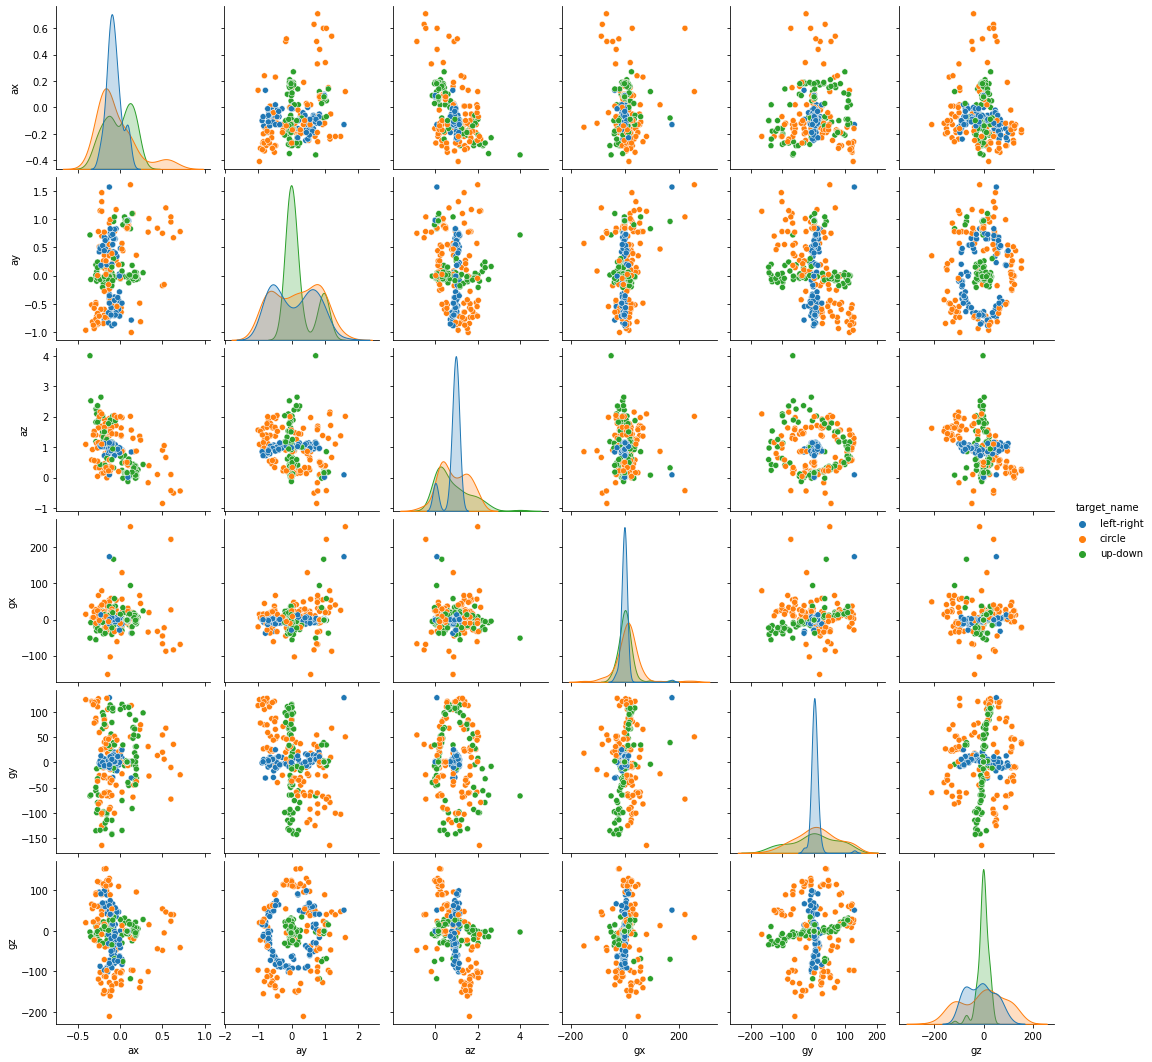

In [11]:
"""
Plot features pairplot
Since this is a time series dataset, the pairplot will no be very informative
We will come back to the pairplot after feature pre-processing to see great improvements!
"""
imu_dataset.plot.features_pairplot(n=300)

## Feature extraction

Now that we have collect our dataset, it is time to extract features from it.

When working with time series data, our go-to feature extractor is a combination of `Window` + `Spectral Features`.

`Window` packs a given number of consecutive readings into a single, large array. You can configure it to overlap each window with the previous by a given amount, so as to capture different time slices of the same event.

![Window example](./assets/rolling-window.jpg)

`SpectralFeatures` takes in input the *windowed* data and extracts a number of statistics from it, for example:

 - min / max
 - absolute value min / max
 - mean value
 - variance and standard deviation
 - [skew](https://en.wikipedia.org/wiki/Skewness) and [kurtosis](https://en.wikipedia.org/wiki/Kurtosis)

In [12]:
from everywhereml.preprocessing import Pipeline, MinMaxScaler, Window, SpectralFeatures

# this is the frequency of your sensor
# change according to your hardware
sampling_frequency = 104
mean_gesture_duration_in_millis = 1000
window_length = sampling_frequency * mean_gesture_duration_in_millis // 1000

imu_pipeline = Pipeline(name='ContinousMotionPipeline', steps=[
    MinMaxScaler(),
    # shift can be an integer (number of samples) or a float (percent)
    Window(length=window_length, shift=0.3),
    # order can either be 1 (first-order features) or 2 (add second-order features)
    SpectralFeatures(order=2)
])

In [13]:
"""
Enumerate features extracted from the SpectralFeatures step
"""
from pprint import pprint

pprint(imu_pipeline['SpectralFeatures'][0].feature_names)

['maximum',
 'minimum',
 'abs_maximum',
 'abs_minimum',
 'mean',
 'abs_energy',
 'mean_abs_change',
 'cid_ce',
 'std',
 'var',
 'count_above_mean',
 'count_below_mean',
 'first_position_of_max',
 'first_position_of_min',
 'max_count',
 'min_count',
 'has_large_std',
 'skew',
 'kurtosis',
 'variation_coefficient']


In [14]:
"""
Apply feature pre-processing
"""
imu_dataset.apply(imu_pipeline)

In [15]:
imu_dataset.describe()

,ax_maximum,ax_minimum,ax_abs_maximum,ax_abs_minimum,ax_mean,ax_abs_energy,ax_mean_abs_change,ax_cid_ce,ax_std,ax_var,...,gz_count_below_mean,gz_first_position_of_max,gz_first_position_of_min,gz_max_count,gz_min_count,gz_has_large_std,gz_skew,gz_kurtosis,gz_variation_coefficient,target
count,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,4.460000e+02,4.460000e+02,...,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,0.586942,0.429874,0.586942,0.429874,0.513022,0.267436,0.007395,0.000443,3.461373e-02,1.695827e-03,...,46.908072,50.943946,52.553812,14.502242,9.029148,0.695067,-0.132979,1.600321,0.216918,1.069507
std,0.091861,0.084704,0.091861,0.084704,0.050534,0.059306,0.006471,0.001529,2.233463e-02,1.869955e-03,...,13.233362,29.509762,28.801693,22.908881,23.152092,0.460896,0.395895,1.692191,0.141367,0.819489
min,0.493007,0.000000,0.493007,0.000000,0.444964,0.198737,0.000000,0.000000,2.220446e-16,4.930381e-32,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-2.757265,0.000000,0.000308,0.000000
25%,0.527972,0.405594,0.527972,0.405594,0.481517,0.232281,0.003267,0.000022,1.621054e-02,2.627815e-04,...,45.000000,28.000000,30.000000,5.000000,1.000000,0.000000,-0.331838,1.418639,0.074097,0.000000
50%,0.562937,0.430070,0.562937,0.430070,0.505026,0.258414,0.006552,0.000096,2.883145e-02,8.312540e-04,...,49.000000,50.000000,51.000000,9.000000,3.000000,1.000000,-0.046329,1.589309,0.234187,1.000000
75%,0.615385,0.461538,0.615385,0.461538,0.530788,0.284050,0.008385,0.000173,5.461791e-02,2.983117e-03,...,54.000000,75.000000,76.000000,13.000000,6.000000,1.000000,0.000000,1.844672,0.356645,2.000000
max,1.000000,0.681818,1.000000,0.681818,0.822250,0.677735,0.053873,0.016381,1.171193e-01,1.371692e-02,...,94.000000,103.000000,103.000000,104.000000,104.000000,1.000000,3.467912,21.711908,0.534780,2.000000


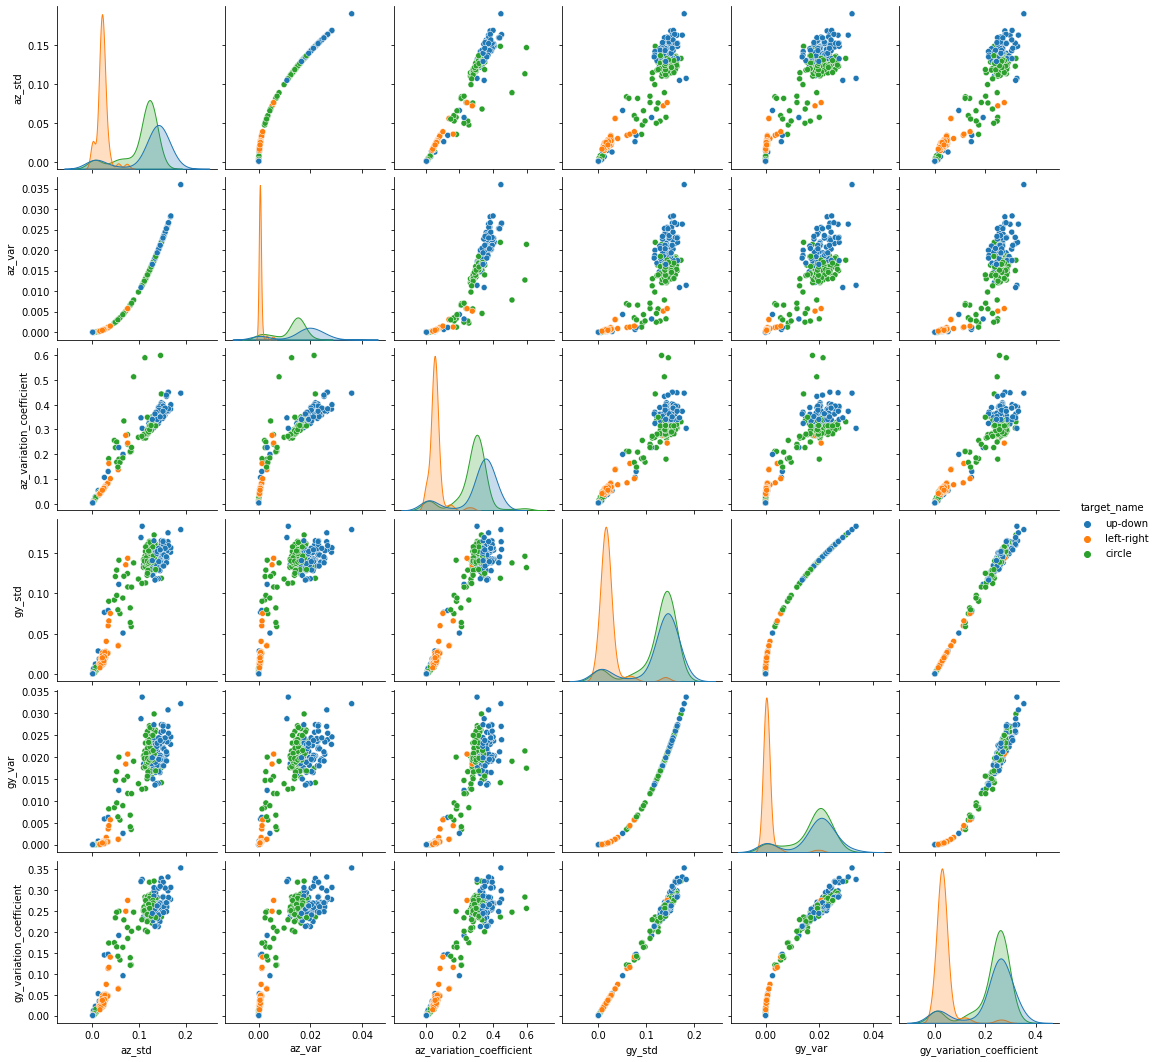

In [16]:
"""
Plot features pairplot after feature extraction
Now it will start to make sense
Since SpectralFeatures generates 8 or 20 features (depending on the order)
for each axis, we limit the visualization to a more reasonable number
"""
imu_dataset.plot.features_pairplot(n=300, k=6)

In [17]:
"""
Perform classification with a RandomForest
"""
from everywhereml.sklearn.ensemble import RandomForestClassifier

imu_classifier = RandomForestClassifier(n_estimators=20, max_depth=20)
imu_train, imu_test = imu_dataset.split(test_size=0.3)
imu_classifier.fit(imu_train)

print('Score on test set: %.2f' % imu_classifier.score(imu_test))

Score on test set: 0.96


As you can see from the plot, the `SpectralFeatures` feature extractor can convert the raw data windows to a meaningful set of features that a classifier can use to accurately predict the gesture.

## Port to Arduino

We need to port two pieces of code to Arduino:

 1. the pre-processing pipeline
 2. the classifier
 
Both of them implement the `to_arduino_file()` function to perform this task.

In [18]:
"""
Port pipeline to C++
"""
print(imu_pipeline.to_arduino_file(
    'sketches/IMUClassify/Pipeline.h', 
    instance_name='pipeline'
))

#ifndef UUID5160611360
#define UUID5160611360

namespace ContinousMotionPipeline {

    
        #ifndef UUID5165167088
#define UUID5165167088

/**
  * MinMaxScaler(low=0, high=1)
 */
class Step0 {
    public:

        /**
         * Transform input vector
         */
        bool transform(float *x) {
            
    for (uint16_t i = 0; i < 6; i++) {
        x[i] = (x[i] - offset[i]) * scale[i] + 0;
    }

    return true;


            return true;
        }

    protected:
        
    float offset[6] = {-1.530000000f, -1.300000000f, -1.010000000f, -850.890000000f, -302.120000000f, -247.990000000f};
    float scale[6] = {0.349650350f, 0.188679245f, 0.199600798f, 0.000472503f, 0.001801639f, 0.001735207f};

};



#endif
    
        #ifndef UUID5165167040
#define UUID5165167040

/**
  * Window(length=104, shift=31)
 */
class Step1 {
    public:

        /**
         * Transform input vector
         */
        bool transform(float *x) {
            
    // append x to queue
    memc

In [19]:
"""
Port classifier to C++
"""
print(imu_classifier.to_arduino_file(
    'sketches/IMUClassify/Classifier.h', 
    instance_name='forest', 
    class_map=imu_dataset.class_map
))

#ifndef UUID5163362720
#define UUID5163362720

/**
  * RandomForestClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=True, ccp_alpha=0.0, class_name=RandomForestClassifier, class_weight=None, criterion=gini, estimator_params=('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'random_state', 'ccp_alpha'), max_depth=20, max_features=auto, max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None, num_outputs=3, oob_score=False, package_name=everywhereml.sklearn.ensemble, random_state=None, template_folder=everywhereml/sklearn/ensemble, verbose=0, warm_start=False)
 */
class RandomForestClassifier {
    public:

        /**
         * Predict class from features
         */
        int predict(float *x) {
            int predictedValue = 0;
            size_t startedAt

With these two pieces in place, it's time to integrate them into a sketch.

```cpp
// file IMUClassify.ino

#include <Arduino_LSM9DS1.h>
#include "Pipeline.h"
#include "Classifier.h"


void setup() {
  Serial.begin(115200);
  Serial.println("Started");

  while (!IMU.begin()) 
    Serial.println("Failed to initialize IMU!");

  Serial.print("Accelerometer sample rate = ");
  Serial.print(IMU.accelerationSampleRate());
  Serial.println("Hz");
}

void loop() {
  float ax, ay, az, gx, gy, gz;
  
  // await for data
  if (!IMU.accelerationAvailable() || !IMU.gyroscopeAvailable())
    return;
    
  IMU.readAcceleration(ax, ay, az);
  IMU.readGyroscope(gx, gy, gz);

  // perform feature extraction
  float features[] = {ax, ay, az, gx, gy, gz};
    
  if (!pipeline.transform(features))
    return;
    
  // perform classification
  Serial.print("Predicted gesture: ");
  Serial.print(forest.predictLabel(pipeline.X));
  Serial.print(" (DSP: ");
  Serial.print(pipeline.latencyInMicros());
  Serial.print(" micros, Classifier: ");
  Serial.print(forest.latencyInMicros());
  Serial.println(" micros)");
}
```

Deploy the sketch to your board and start performing each gesture.

Based on the length of your gestures and the complexity of the classifier, you can expect sub-millisecond DSP time if using first-order features only and 100-200 microseconds for classification.